In [76]:
import numpy as np
from qiskit import IBMQ, Aer, assemble, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

from qiskit.visualization import plot_histogram

provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))

ibmqfactory.load_account:WARNING:2022-05-10 03:46:13,718: Credentials are already in use. The existing account in the session will be replaced.


Here we present two application examples of quantum error correcting codes: the Shor Code for correction on a noisy communication channel and the Steane code for a fault-tolerant 2-qubit Grover's algorithm

# The Shor Code

In [80]:
# TODO: add to a class
def encode(circuit):
        n = circuit.width()

        # encoder circuit for every qubit
        # store number of main (non-auxilary) qubits for the decoder
        encoder = QuantumCircuit(n*9, metadata={'n': 1})
        for i in range(n):
            f = 9*i
            encoder.cx(f,f+3)
            encoder.cx(f,f+6)

            encoder.h(f)
            encoder.h(f+3)
            encoder.h(f+6)

            encoder.cx(f,f+1)
            encoder.cx(f+3,f+4)
            encoder.cx(f+6,f+7)

            encoder.cx(f,f+2)
            encoder.cx(f+3,f+5)
            encoder.cx(f+6,f+8)

        encoder.barrier()
        combined = encoder
        for j in range(9):
            combined = combined.compose(circuit, [9*i + j for i in range(n)])

            
        
        combined.x(0)
        combined.z(0)
        combined.barrier()
        return combined


def decode(circuit):
        n = circuit.width()
        if circuit.metadata['n']:
            n = circuit.metadata['n']

        decoder = QuantumCircuit(n*9, metadata={'n': 1})
        for i in range(n):
            f = 9*i
            decoder.cx(f,f + 1)
            decoder.cx(f + 3, f + 4)    
            decoder.cx(f + 6,f + 7)

            decoder.cx(f,f + 2)
            decoder.cx(f + 3,f + 5)
            decoder.cx(f + 6,f + 8)

            decoder.ccx(f + 1,f + 2,f + 0)
            decoder.ccx(f + 4,f + 5,f + 3)
            decoder.ccx(f + 8,f + 7,f + 6)

            decoder.h(f)
            decoder.h(f + 3)
            decoder.h(f + 6)

            decoder.cx(f + 0, f+ 3)
            decoder.cx(f + 0,f + 6)
            decoder.ccx(f + 6, f + 3, f)
        return circuit.compose(decoder)

    

    

Transmission through a noisy channel

In [ ]:
uncorrec = QuantumCircuit(1)
cl = ClassicalRegister(1)
qcc.add_register(cl)

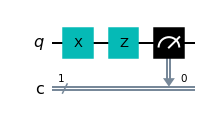

In [84]:
q = QuantumRegister(1, 'q')
c = ClassicalRegister(1, 'c')
qc = QuantumCircuit(q, c)


qc.x(0)
qc.z(0)
qc.measure(0, c)
qc.draw(output="mpl")

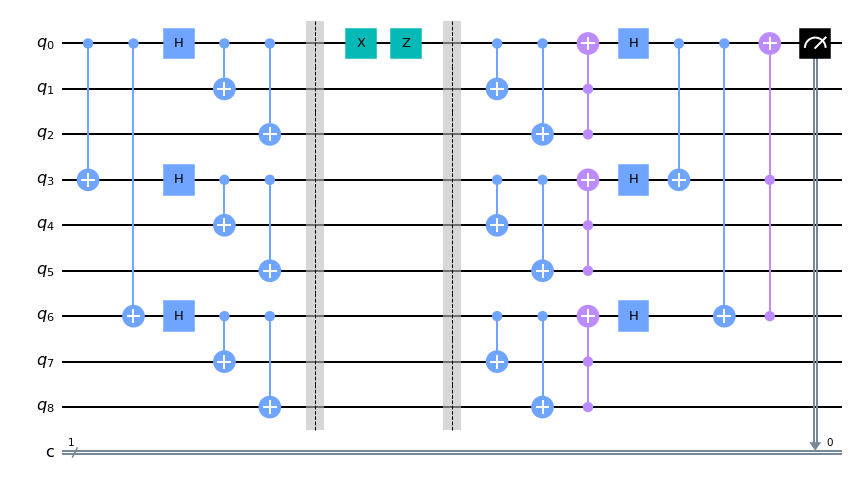

In [86]:
corrected_qc = decode(encode(QuantumCircuit(1)))
c = ClassicalRegister(1, 'c')
corrected_qc.add_register(c)
result = corrected_qc.measure(0, c)
corrected_qc.draw(output="mpl")

Running simulation for uncorrected circuit

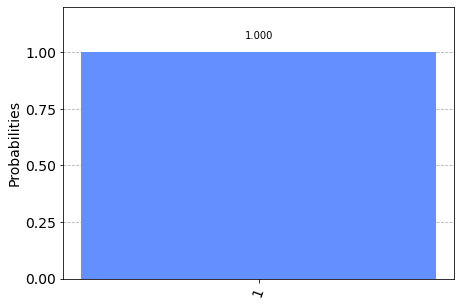

In [89]:
# TODO: run on real computers
aer_sim = Aer.get_backend('aer_simulator')
result = aer_sim.run(assemble(qc)).result()
counts = result.get_counts()
plot_histogram(counts)

For the corrected circuit

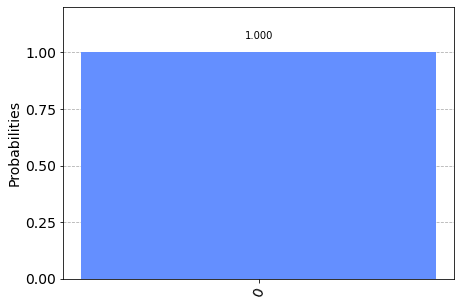

In [90]:
aer_sim = Aer.get_backend('aer_simulator')
result = aer_sim.run(assemble(corrected_qc)).result()
counts = result.get_counts()
plot_histogram(counts)

# The Grover Circuit

A simple 2-qubit Grover circuit for searching the |11> state

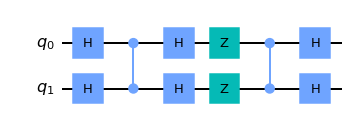

In [91]:
grover_circuit = QuantumCircuit(2)

grover_circuit.h(0)
grover_circuit.h(1)
grover_circuit.cz(0,1) 
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])

grover_circuit.draw(output="mpl")


Running the circuit without errors to get the expected result.

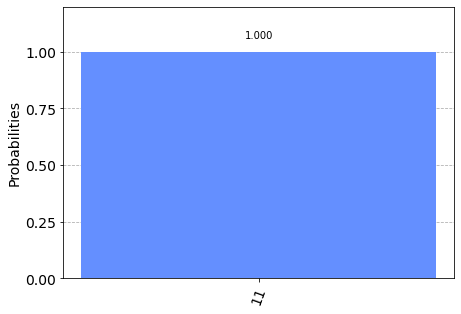

In [92]:
grover_circuit.measure_all()
result = aer_sim.run(assemble(grover_circuit)).result()
counts = result.get_counts()
plot_histogram(counts)

# The Steane Code

In [93]:
# Measures logical_qubit in the Z basis using ancilla
def logical_z_measure(qc, ancilla, target, measurement):
    qc.initialize([1, 0],ancilla)
    qc.h(ancilla)
    qc.cz(ancilla, target)
    qc.h(ancilla)
    qc.measure(ancilla, measurement)

In [94]:
class SteaneCode:
    # initialize a circuit for Steane code on logical_qubits
    def __init__(self, logical_qubits):
        self.n = len(logical_qubits)
        self.encoded_qubits = []
        self.additional_qubits = {}


        self.additional_qubits['x_anc'] = QuantumRegister(3, 'x_anc')
        self.additional_qubits['z_anc'] = QuantumRegister(3, 'z_anc')
        self.additional_qubits['x_synd'] = ClassicalRegister(3, 'x_synd')
        self.additional_qubits['z_synd'] = ClassicalRegister(3, 'z_synd')

        for i in range(self.n ):
            self.encoded_qubits.append({})
            self.encoded_qubits[i]['logical'] = logical_qubits[i]
            self.encoded_qubits[i]['meas_anc'] = QuantumRegister(1, 'meas_anc' + str(i))
            self.encoded_qubits[i]['meas'] = ClassicalRegister(1, 'meas' + str(i))
    
    # prepare encoded qubits of the circuit
    def prepare(self):
        qc = QuantumCircuit()

        x_anc = self.additional_qubits['x_anc']
        z_anc = self.additional_qubits['z_anc']
        x_synd = self.additional_qubits['x_synd']
        z_synd = self.additional_qubits['z_synd']

        qc.add_register(x_anc, z_anc, x_synd, z_synd)

        for i in range(self.n):
            logical = self.encoded_qubits[i]['logical']
            meas_anc = self.encoded_qubits[i]['meas_anc']
            meas = self.encoded_qubits[i]['meas']

            qc.add_register(logical,  meas_anc, meas)
        self.qc = qc
        self.correct_all()

            
    # correct the specified logical qubits
    def correct(self, *indices):
        qc = self.qc
        
        x_anc = self.additional_qubits['x_anc']
        z_anc = self.additional_qubits['z_anc']
        x_synd = self.additional_qubits['x_synd']
        z_synd = self.additional_qubits['z_synd']

        for i in indices:
            logical = self.encoded_qubits[i]['logical']

            for i in range(3):
                qc.initialize([1, 0], x_anc[i])
                qc.initialize([1, 0], z_anc[i])

            qc.h(x_anc)
            qc.h(z_anc)
        
            qc.cx(z_anc[2], [logical[i-1] for i in [4,5,6,7]]) # Controlled g1
            qc.cx(z_anc[1], [logical[i-1] for i in [2,3,6,7]]) # Controlled g2
            qc.cx(z_anc[0], [logical[i-1] for i in [1,3,5,7]]) # Controlled g3
            
            qc.cz(x_anc[2], [logical[i-1] for i in [4,5,6,7]]) # Controlled g4
            qc.cz(x_anc[1], [logical[i-1] for i in [2,3,6,7]]) # Controlled g5
            qc.cz(x_anc[0], [logical[i-1] for i in [1,3,5,7]]) # Controlled g6

            qc.h(x_anc)
            qc.h(z_anc)

            qc.measure(x_anc, x_synd)
            qc.measure(z_anc, z_synd)

            for i in range(1,8):
                qc.x(logical[i-1]).c_if(x_synd,i)
    
            # Apply the corrective Z gates
            for i in range(1,8):
                qc.z(logical[i-1]).c_if(z_synd,i)


    # measure specified qubits
    def measure(self, *indices):
        qc = self.qc
        for i in indices:
            logical = self.encoded_qubits[i]['logical']
            meas_anc = self.encoded_qubits[i]['meas_anc']
            meas = self.encoded_qubits[i]['meas']
            logical_z_measure(qc, meas_anc, logical, meas)

    
    # add errors to randum physical qubits of specified logical qubits
    def add_errors(self, *indices):
        qc = self.qc
        for i in indices:
            logical = self.encoded_qubits[i]['logical']
            qc.x(logical[np.random.randint(0,6+1)])
            qc.z(logical[np.random.randint(0,6+1)])

    # correct all qubits
    def correct_all(self):
        self.correct(*range(self.n))
        
    # measure all qubits
    def measure_all(self):
        self.measure(*range(self.n))

    # add errors to randum physical qubits of all logical qubits
    def add_errors_all(self):
        self.add_errors(*range(self.n))

In [98]:
sim = Aer.get_backend('aer_simulator_extended_stabilizer')

def error_grover(correct = False):
    logical0 = QuantumRegister(7, 'logical_qubit0')
    logical1 = QuantumRegister(7, 'logical_qubit1')

    # initialize steane code and prepare logical encoded states
    stean_code = SteaneCode([logical0, logical1])
    stean_code.prepare()

    ### Grover

    # uniform superposition
    stean_code.qc.h(logical0)
    stean_code.qc.h(logical1)

    # add and correct errors, assuming that correction is performed periodically
    stean_code.add_errors_all()
    if correct:
        stean_code.correct_all()

    # oracle
    stean_code.qc.cz(logical0, logical1)
    
    # diffuser
    stean_code.qc.h(logical0)
    stean_code.qc.h(logical1)
    stean_code.qc.z(logical0)
    stean_code.qc.z(logical1)
    stean_code.qc.cz(logical0, logical1)
    stean_code.qc.h(logical0)
    stean_code.qc.h(logical1)
    

    stean_code.measure_all()
    return stean_code.qc

Simulating for Grover with errors, we get a wrong result: the state |00> instead of the expected |11>

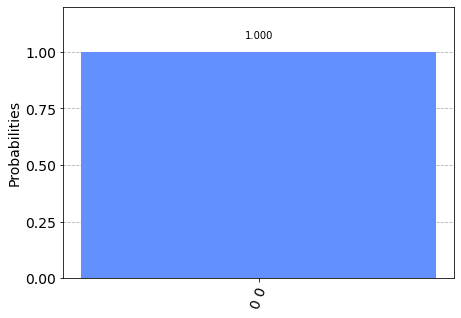

In [100]:
net_counts = {}
qc = error_grover()
counts = execute(qc, sim, shots=10000).result().get_counts()

for key in counts.keys():
    truncated_key = key[0:3][::-1] 
    if truncated_key in net_counts.keys():
        net_counts[truncated_key] += counts[key]
    else:
        net_counts[truncated_key] = counts[key]

plot_histogram(net_counts)

Run the same simulation, with enabled error correction to get the correct result |11>

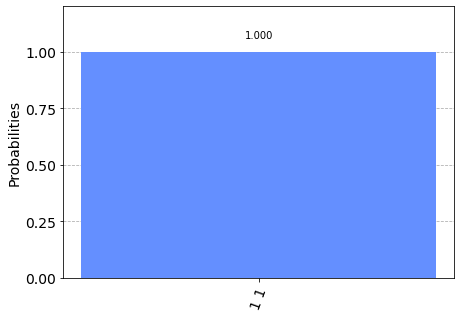

In [101]:
net_counts = {}
qc = error_grover(True)
counts = execute(qc, sim, shots=10000).result().get_counts()

for key in counts.keys():
    truncated_key = key[0:3][::-1] 
    if truncated_key in net_counts.keys():
        net_counts[truncated_key] += counts[key]
    else:
        net_counts[truncated_key] = counts[key]

plot_histogram(net_counts)

The Steane-corrected Grover circuit looks as follows 

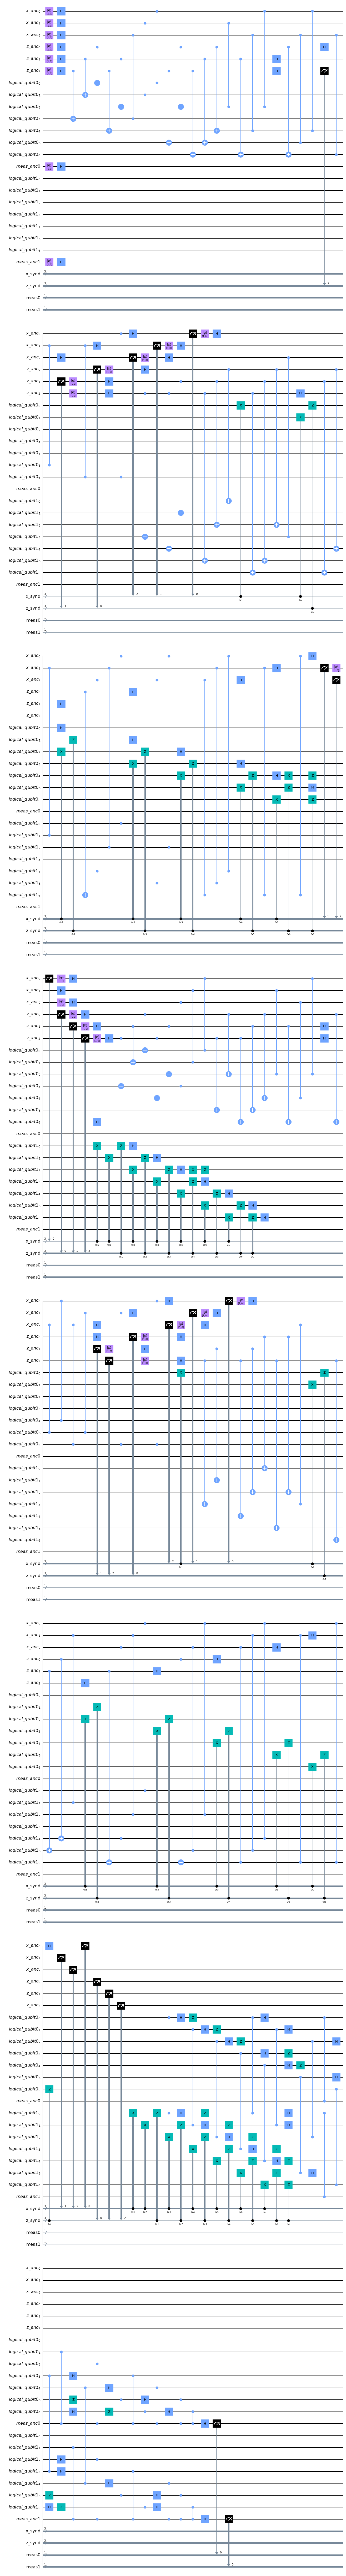

In [102]:
qc.draw(output="mpl")

The circuit width (number of qubits) and size (number of gates) make it impossible for this simulation to be run on an actual IBM cloud quantum computer with the free quota.

In [105]:
qc.size()

344

In [106]:
qc.width()

30

In [95]:
# # run on real machines

# print("Running on current least busy device: ", device)

# # Run our circuit on the least busy backend. Monitor the execution of the job in the queue
# transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
# job = device.run(transpiled_grover_circuit)
# job_monitor(job, interval=2)


# # Get the results from the computation
# results = job.result()
# answer = results.get_counts(grover_circuit)
# plot_histogram(answer)